In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Data Preprocessing

In [2]:
train_dir = 'Datasets\Brain Tumor Dataset\Training'
test_dir = 'Datasets\Brain Tumor Dataset\Testing'

In [3]:
img_size = (128, 128)  
batch_size = 32

In [4]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)


In [5]:
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

Found 4571 images belonging to 4 classes.


In [6]:
val_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 1141 images belonging to 4 classes.


In [7]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1311 images belonging to 4 classes.


Batch images shape: (32, 128, 128, 3)
Batch labels shape: (32, 4)


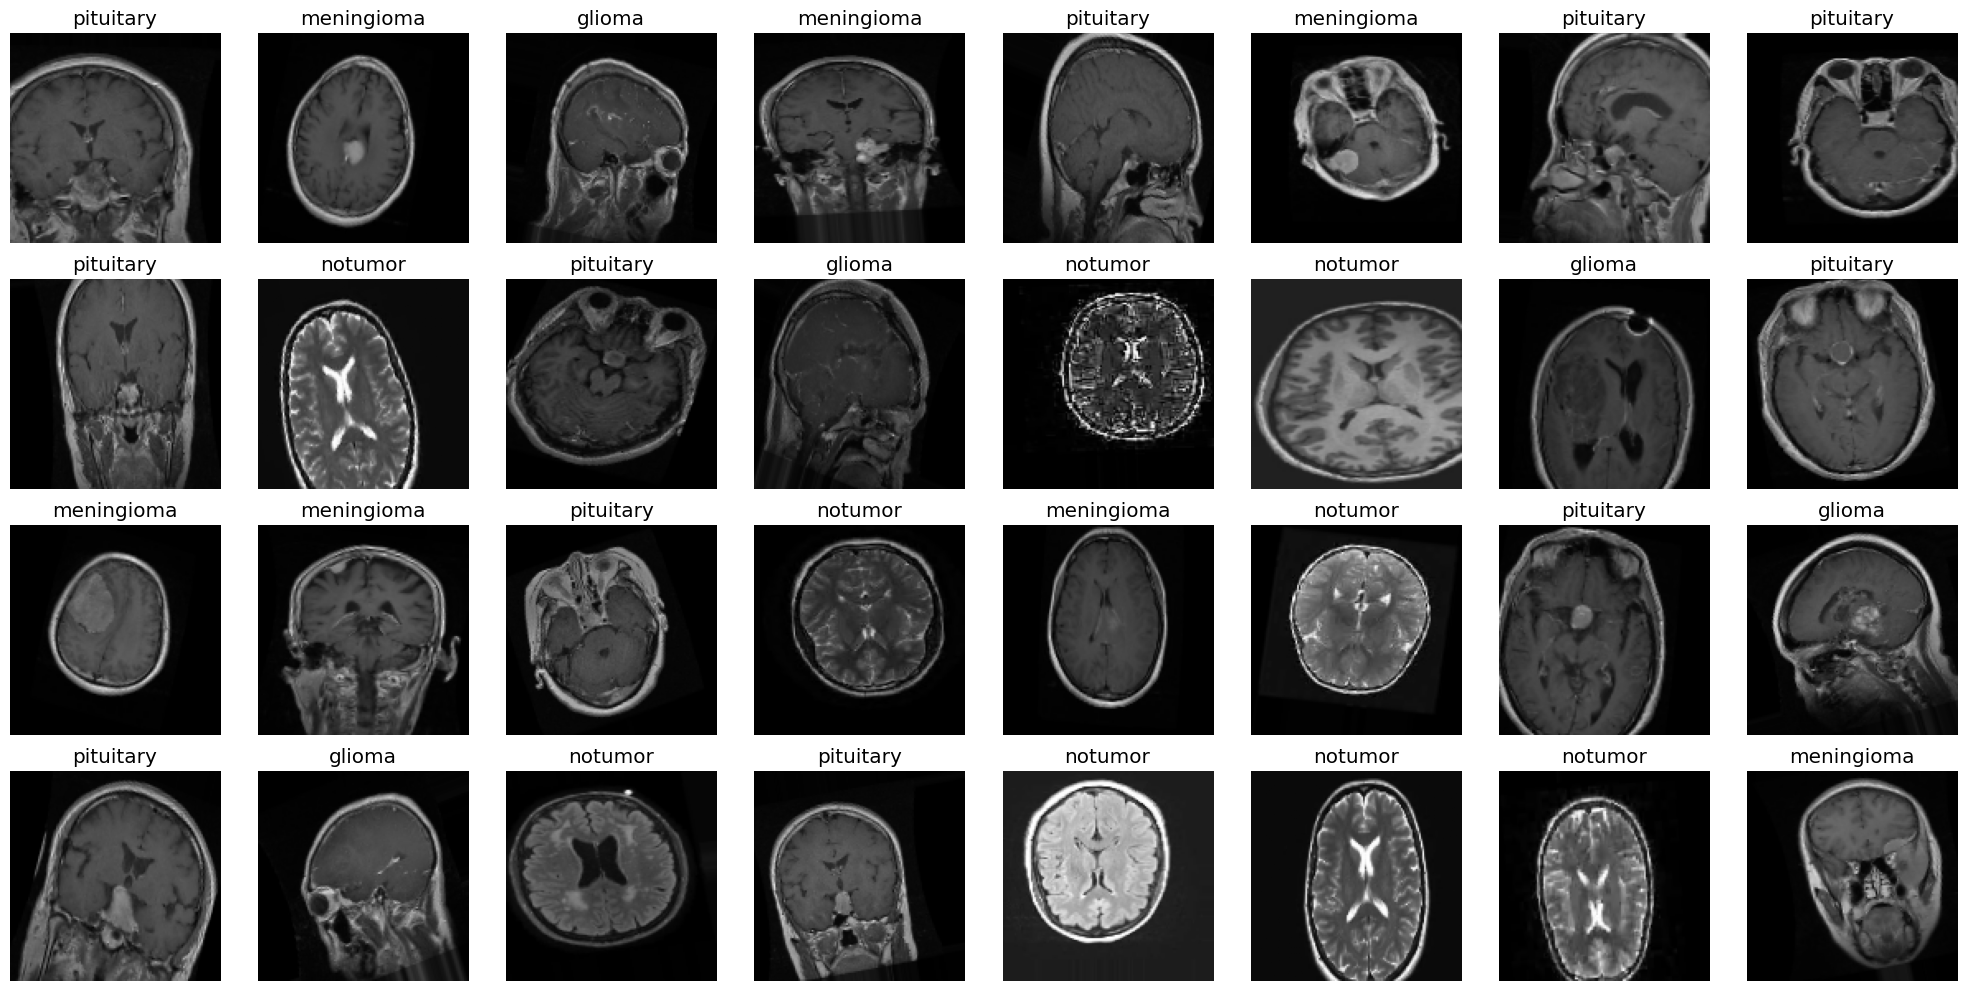

In [8]:
# Take one batch
images, labels = next(train_generator)

print("Batch images shape:", images.shape)
print("Batch labels shape:", labels.shape)

# Show the batch
plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i])  # float images already in [0,1], so no need to cast
    plt.title(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
#CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")  # 4 classes
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
# Training
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_cnn_model.keras", save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 375ms/step - accuracy: 0.5461 - loss: 0.9936 - val_accuracy: 0.6696 - val_loss: 0.8979
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 356ms/step - accuracy: 0.7012 - loss: 0.7131 - val_accuracy: 0.6775 - val_loss: 0.8216
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 353ms/step - accuracy: 0.7510 - loss: 0.6258 - val_accuracy: 0.7187 - val_loss: 0.7508
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 351ms/step - accuracy: 0.7639 - loss: 0.5960 - val_accuracy: 0.6985 - val_loss: 0.8127
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 355ms/step - accuracy: 0.7902 - loss: 0.5508 - val_accuracy: 0.7152 - val_loss: 0.7283
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 353ms/step - accuracy: 0.8077 - loss: 0.4937 - val_accuracy: 0.7222 - val_loss: 0.7634
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 445ms/step - accuracy: 0.8136 - loss: 0.4897 - val_accuracy: 0.7493 - val_loss: 0.6516
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 503ms/step - accuracy: 0.8265 - loss: 0

In [11]:
# Evaluation
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.8246 - loss: 0.5313
Test Accuracy: 82.46%


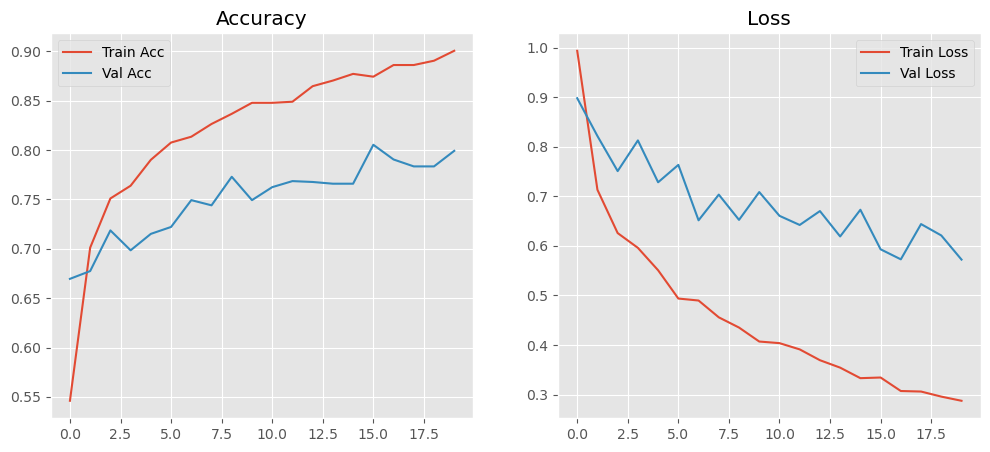

In [12]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [13]:
# Confusion Matrix & Report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:\n", classification_report(
    test_generator.classes, y_pred_classes,
    target_names=list(test_generator.class_indices.keys())
))

cm = confusion_matrix(test_generator.classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.75      0.82       300
  meningioma       0.74      0.59      0.66       306
     notumor       0.78      1.00      0.88       405
   pituitary       0.90      0.91      0.90       300

    accuracy                           0.82      1311
   macro avg       0.83      0.81      0.81      1311
weighted avg       0.83      0.82      0.82      1311

Confusion Matrix:
 [[225  55   9  11]
 [ 17 181  89  19]
 [  2   0 403   0]
 [  7   7  14 272]]
